# Building and Assessing ML Models

## 1. Import needed modules

In [1]:
using Downloads
using CSV
using MLJ
using DataFrames
using GLM
using ROCCurves
using FreqTables
using StatsPlots

## 2. Data Loading, pre-processing and splitting into train and validation subsets

### Data loading & pre-processing

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat"
Downloads.download(url, "australian.csv")

"australian.csv"

In [3]:
dataset = CSV.read("australian.csv", DataFrame, delim=' ';
                header = append!([string("V", i) for i in 0:13], ["class"]))

Row,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,class
,Int64,Float64,Float64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
2,0,22.67,7.0,2,8,4,0.165,0,0,0,0,2,160,1,0
3,0,29.58,1.75,1,4,4,1.25,0,0,0,1,2,280,1,0
4,0,21.67,11.5,1,5,3,0.0,1,1,11,1,2,0,1,1
5,1,20.17,8.17,2,6,4,1.96,1,1,14,0,2,60,159,1
6,0,15.83,0.585,2,8,8,1.5,1,1,2,0,2,100,1,1
7,1,17.42,6.5,2,3,4,0.125,0,0,0,0,2,60,101,0
8,0,58.67,4.46,2,11,8,3.04,1,1,6,0,2,43,561,1
9,1,27.83,1.0,1,2,8,3.0,0,0,0,0,2,176,538,0


In [4]:
dataset.V3 = ifelse.(dataset.V3 .== 1, 0, 1)
dataset.V11 = ifelse.(dataset.V11 .== 1, 0, 1)
dataset.V13 = log.(dataset.V13) 
dataset

Row,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,class
,Int64,Float64,Float64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64
1,1,22.08,11.46,1,4,4,1.585,0,0,0,1,1,100,7.10085,0
2,0,22.67,7.0,1,8,4,0.165,0,0,0,0,1,160,0.0,0
3,0,29.58,1.75,0,4,4,1.25,0,0,0,1,1,280,0.0,0
4,0,21.67,11.5,0,5,3,0.0,1,1,11,1,1,0,0.0,1
5,1,20.17,8.17,1,6,4,1.96,1,1,14,0,1,60,5.0689,1
6,0,15.83,0.585,1,8,8,1.5,1,1,2,0,1,100,0.0,1
7,1,17.42,6.5,1,3,4,0.125,0,0,0,0,1,60,4.61512,0
8,0,58.67,4.46,1,11,8,3.04,1,1,6,0,1,43,6.32972,1
9,1,27.83,1.0,0,2,8,3.0,0,0,0,0,1,176,6.28786,0


In [5]:
training_fraction = 0.6
train, test = partition(eachindex(dataset.class), training_fraction, shuffle=true)

([459, 271, 516, 197, 492, 559, 310, 527, 36, 557  …  624, 374, 464, 266, 489, 531, 274, 659, 275, 154], [432, 510, 114, 90, 370, 252, 360, 543, 205, 136  …  430, 93, 612, 296, 147, 342, 135, 423, 178, 585])

In [6]:
train_dataset = dataset[train,:]
test_dataset = dataset[test,:]

Row,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,class
,Int64,Float64,Float64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64
1,1,32.08,4.0,0,13,4,1.5,0,0,0,1,1,120,0.0,0
2,1,29.17,3.5,1,9,4,3.5,1,1,3,1,1,329,0.0,0
3,0,35.75,0.915,1,6,4,0.75,1,1,4,0,1,0,7.36771,1
4,1,22.17,0.585,0,1,1,0.0,0,0,0,0,1,100,0.0,0
5,1,33.58,2.75,1,7,4,4.25,1,1,6,0,1,204,0.0,1
6,1,24.5,13.335,0,6,4,0.04,0,0,0,1,1,120,6.16542,0
7,1,25.17,3.0,1,8,4,1.25,0,1,1,0,1,0,3.13549,0
8,1,44.0,2.0,1,7,4,1.75,1,1,2,1,1,0,2.77259,1
9,0,24.75,3.0,1,11,8,1.835,1,1,19,0,1,0,6.21661,1


In [7]:
size.([train_dataset, test_dataset])

2-element Vector{Tuple{Int64, Int64}}:
 (414, 15)
 (276, 15)

## 3. Building logistic regression model
[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)

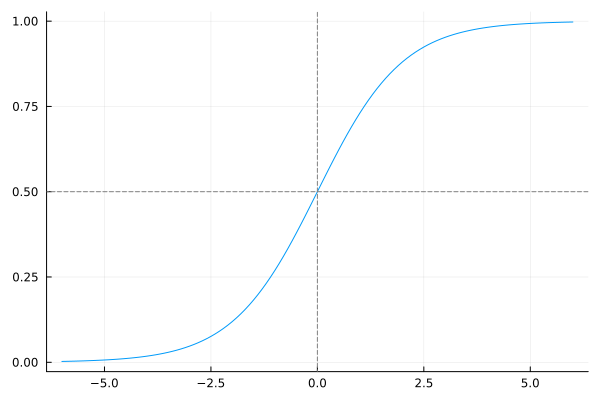

In [8]:
logistic(x) = 1 / (1 + exp(-x))
x = collect(-6:.1:6)
plot(x, logistic.(x), legend=false)
vline!([0], line=:dash, color=:grey)
hline!([1/2], line=:dash, color=:grey)

In [9]:
model_log_reg_fit = glm(Term(:class) ~ sum(Term.(Symbol.(names(dataset[:, Not(:class)])))),
                        train_dataset, Binomial())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

class ~ 1 + V0 + V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11 + V12 + V13

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)  -5.76872     0.970065    -5.95    <1e-08  -7.67001     -3.86742
V0            0.223954    0.344064     0.65    0.5151  -0.450399     0.898307
V1           -0.00686072  0.0147643   -0.46    0.6422  -0.0357983    0.0220768
V2           -0.0272429   0.032815    -0.83    0.4064  -0.0915593    0.0370734
V3            1.55878     0.407976     3.82    0.0001   0.759163     2.3584
V4            0.171125    0.0526641  

Model coefficients:

In [10]:
coef(model_log_reg_fit)

15-element Vector{Float64}:
 -5.768717292595348
  0.22395404358420756
 -0.006860724606511331
 -0.02724294990672241
  1.5587815595434713
  0.1711253660093458
  0.012355226919253684
  0.05605700759469912
  3.545486177270827
  0.37881066553622467
  0.043928737250339564
 -0.07935471592687399
  0.7714038632965892
 -0.0019437746703103035
  0.10968607136420264

### Prediction

In [11]:
train_pred = GLM.predict(model_log_reg_fit)

414-element Vector{Float64}:
 0.05132617077699623
 0.0713400292360758
 0.42369246791884246
 0.9614536548996401
 0.9631246271437536
 0.04624305130048847
 0.11824054807953928
 0.46440376025501406
 0.010891581750002037
 0.017191114487225666
 0.7915445238640908
 0.996783359148715
 0.12729966655321265
 ⋮
 0.10282241843162046
 0.004059412585487381
 0.09585930395530654
 0.19144217212856357
 0.7763689944592848
 0.18459703504194022
 0.8727679517229435
 0.023903558833418607
 0.28766816689615754
 0.011917892016731975
 0.9216227353256558
 0.03304868557594933

In [12]:
test_pred = GLM.predict(model_log_reg_fit, test_dataset)

276-element Vector{Union{Missing, Float64}}:
 0.044920739933232326
 0.8338163556372578
 0.9103268718937163
 0.007017572200083892
 0.8528336479434698
 0.02057953890904941
 0.22902291748172887
 0.8819863818753404
 0.9788520958413247
 0.06254080233502611
 0.005659681820683602
 0.11121916774954158
 0.7565809981004386
 ⋮
 0.9461936225632
 0.021906858382994502
 0.7622678551199196
 0.05803879420071172
 0.007148752840213558
 0.0059614632865997086
 0.9304253677833474
 0.7396983463618158
 0.5085586924227378
 0.009017431645606283
 0.01432662992732805
 0.03164629412410212

In [13]:
ideal_pred = test_dataset.class

276-element Vector{Int64}:
 0
 0
 1
 0
 1
 0
 0
 1
 1
 0
 0
 0
 1
 ⋮
 1
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0

In [14]:
random_pred = rand(length(test_dataset.class))

276-element Vector{Float64}:
 0.5276872131115365
 0.6204009833106437
 0.46352216358237286
 0.5484400172369874
 0.07606987655730346
 0.16116944680873302
 0.6085015544640081
 0.5318567618118462
 0.8936394968883958
 0.39266426810767396
 0.7434010169554206
 0.3240523075353169
 0.0840219545934231
 ⋮
 0.4797026162895618
 0.1191009695612757
 0.8670065576047145
 0.5223214879389846
 0.0030239912560622306
 0.23791176328407826
 0.9008848074524437
 0.7514789401921824
 0.41203547873582824
 0.8812975085273232
 0.34389542542519513
 0.7122939399298905

## 4. Assessing model performance


### Descriptive analysis - confusion matrix and related metrics

❗ Remember class indicator (0, 1,...) and actual or predicted values may be switched in confusion matrix

<img src="https://miro.medium.com/max/712/1*Z54JgbS4DUwWSknhDCvNTQ.png" width=400>

<img src="https://miro.medium.com/max/1780/1*LQ1YMKBlbDhH9K6Ujz8QTw.jpeg"  width=400>

**Performance measures derived from confusion matrix:**

- Accuracy - percentage of correct predictions

`ACC = (TP + TN)/(TP + FP + TN + FN)`

- Precision - percentage of positive predictions which were actually correct

`PREC = TP / (TP + FP)`

-  Recall - what percentage of actual positives were predicted correctly
 (Recall = Sensitivity = Hit rate = True Positive Rate (TPR))
 
`REC = TP / (TP + FN)`

- Specificity - what percentage of actual negatives were predicted correctly (Specificity = True Negative Rate)

`TNR = TN / (TN + FP)`

- F1 Score - traditional F-measure or balanced F-score (F1 score) is the harmonic mean of precision and recall

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/1bf179c30b00db201ce1895d88fe2915d58e6bfd)

Calculating confusion matrices for prediction on train and test data as well as random and wizard models with a 0.5 cut-off threshold:

In [15]:
conf_mat_train = freqtable(train_pred .> 0.5, train_dataset.class)

2×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │   0    1
────────────┼─────────
false       │ 206   19
true        │  27  162

In [16]:
conf_mat_test = freqtable(test_pred .> 0.5, test_dataset.class)

2×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │   0    1
────────────┼─────────
false       │ 126   17
true        │  24  109

In [17]:
conf_mat_ideal = freqtable(ideal_pred .> 0.5, test_dataset.class)

2×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │   0    1
────────────┼─────────
false       │ 150    0
true        │   0  126

In [18]:
conf_mat_random = freqtable(random_pred .> 0.5, test_dataset.class)

2×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │  0   1
────────────┼───────
false       │ 74  63
true        │ 76  63

Writing a function to calculate accuracy, precision, recall and f1-score:

In [19]:
function quality_report(mat::AbstractMatrix)
    acc = (mat[1,1] + mat[2,2]) / sum(mat)
    prec = mat[2,2] / sum(mat[2,:])
    rec = mat[2,2] / sum(mat[:,2])
    f1 = 2 * prec * rec / (prec + rec)
    println("----Classification quality report----")
    println("Accuracy: ", round(acc*100,digits=2), "%")
    println("Precision: ", round(prec*100,digits=2), "%")
    println("Recall: ", round(rec*100,digits=2), "%")
    println("F1-score: ", round(f1*100,digits=2), "%")
end

quality_report (generic function with 1 method)

Printing the reports for both datasets, as well as wizard and random models. Results are quite close similar to what we have seen on ROC curves:

In [20]:
println("Train set")
quality_report(conf_mat_train)
println("\nTest set")
quality_report(conf_mat_test)
println("\nWizard model:")
quality_report(conf_mat_ideal)
println("\nRandom model:")
quality_report(conf_mat_random)

Train set
----Classification quality report----
Accuracy: 88.89%
Precision: 85.71%
Recall: 89.5%
F1-score: 87.57%

Test set
----Classification quality report----
Accuracy: 85.14%
Precision: 81.95%
Recall: 86.51%
F1-score: 84.17%

Wizard model:
----Classification quality report----
Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0%

Random model:
----Classification quality report----
Accuracy: 49.64%
Precision: 45.32%
Recall: 50.0%
F1-score: 47.55%


### Visual analysis of a model

#### ROC curve

Calculating and plotting ROC curves for both training and test datasets as well as for wizard and random models:

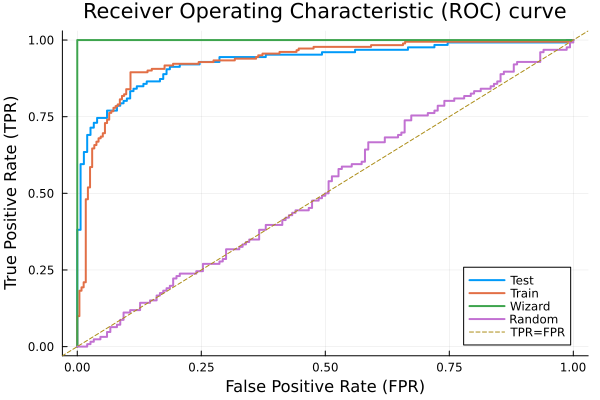

In [21]:
train_fpr, train_tpr = ROCCurves.roc(train_pred, train_dataset.class)
test_fpr, test_tpr = ROCCurves.roc(test_pred, test_dataset.class)
ideal_fpr, ideal_tpr = ROCCurves.roc(ideal_pred, test_dataset.class)
random_fpr, random_tpr = ROCCurves.roc(random_pred, dataset.class[test])

plot(test_fpr, test_tpr, label="Test", xlabel="False Positive Rate (FPR)",
    ylabel="True Positive Rate (TPR)",
    title ="Receiver Operating Characteristic (ROC) curve", linewidth=2, legend=:bottomright)
plot!(train_fpr, train_tpr, label="Train", linewidth=2)
plot!(ideal_fpr, ideal_tpr, label="Wizard", linewidth=2)
plot!(random_fpr, random_tpr, label="Random", linewidth=2)
Plots.abline!(1, 0, line=:dash, label = "TPR=FPR")

Ideal model has ROC composed of 1-point at $(0, 1)$ resulting in perfect identification of $Y=1$ while making no errors. The better model, the closer its ROC is to this ideal point of $(0,1)$ resulting also in higher area the curve, which is numerical measurement of model performance presented below.

### AUC - Area Under Curve

Calculating AUC for training, test data and wizard and random models:

In [22]:
println("AUC metric on train dataset is equal to: ", auc_roc(train_fpr, train_tpr))
println("AUC metric on test dataset is equal to: ", auc_roc(test_fpr, test_tpr))
println("AUC metric of wizard model is equal to: ", auc_roc(ideal_fpr, ideal_tpr))
println("AUC metric of random model is equal to: ", auc_roc(random_fpr, random_tpr))

AUC metric on train dataset is equal to: 0.9305479809356692
AUC metric on test dataset is equal to: 0.9309523809523809
AUC metric of wizard model is equal to: 1.0
AUC metric of random model is equal to: 0.5167195767195766


- discrepancy beetween train and test AUC measurement is the sign of overfitting
- wizard model would have AUC equal to 1 and random model around 0.5
- simulating ROC for random model with the same number of observation as test set has, enables to understand the sampling error of test set ROC 

### Gain chart

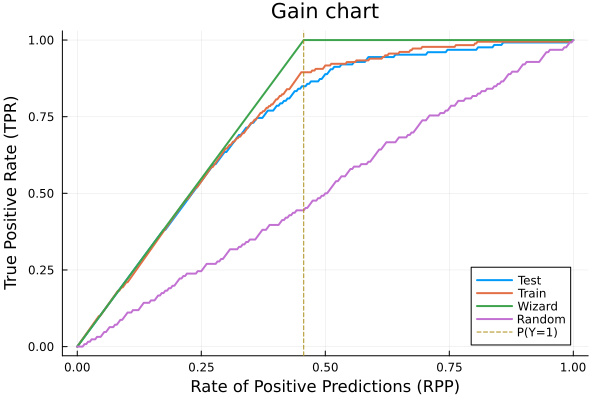

In [23]:
test_rpp = collect(0:length(test_tpr)-1)./(length(test_tpr)-1)
train_rpp = collect(0:length(train_tpr)-1)./(length(train_tpr)-1)

plot(test_rpp, test_tpr, label="Test", xlabel="Rate of Positive Predictions (RPP)",
     ylabel="True Positive Rate (TPR)", title= "Gain chart", linewidth=2, legend=:bottomright)
plot!(train_rpp, train_tpr, label="Train", linewidth=2)
plot!(test_rpp, ideal_tpr, label="Wizard", linewidth=2)
plot!(test_rpp, random_tpr, label="Random", linewidth=2)
vline!([mean(dataset.class[test])] ,line=:dash, label = "P(Y=1)")

- wizard model will increase linearly, so it achieves maximum of $TPR = 1$ for $RPP = P(Y=1)$
- random model gain chart is around 45-degree line

### Lift chart

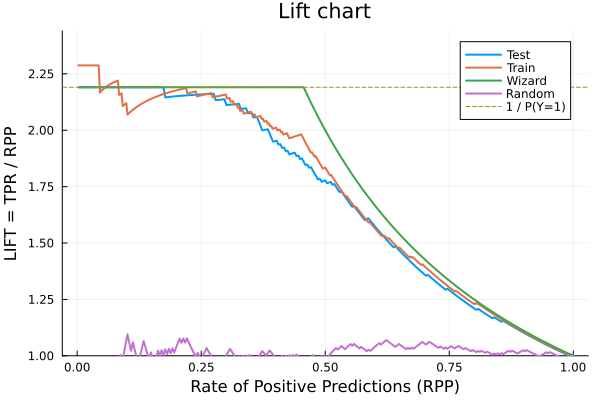

In [24]:
plot(test_rpp, test_tpr ./ test_rpp, label="Test", xlabel="Rate of Positive Predictions (RPP)",
     ylabel="LIFT = TPR / RPP", title= "Lift chart", linewidth=2, legend=:topright,
     ylim = (1, 0.25+1/mean(dataset.class[test])))
plot!(train_rpp, train_tpr ./ train_rpp, label="Train", linewidth=2)
plot!(test_rpp, ideal_tpr ./ test_rpp, label="Wizard", linewidth=2)
plot!(test_rpp, random_tpr ./ test_rpp, label="Random", linewidth=2)
Plots.abline!(0, 1/mean(dataset.class[test]),  
     line=:dash, label = "1 / P(Y=1)")

- Lift measures how many times model's TPR is higher in comparison to TPR of random model for a given RPP, e.g. LIFT = 2 means that models indetifies 2 times more label $Y=1$ than a random model.
- Wizard model LIFT is equal to $ 1/P(Y=1)$ for $RPP < P(Y=1)$ and afterward decrease hiperbolically towards $LIFT =1$, which is a benchmark value for a random model. 

#### Score-density plots
Predicting labels on test dataset:

In [25]:
test_pred_1 = test_pred[test_dataset.class .== 1]
test_pred_0 = test_pred[test_dataset.class .== 0];

Visualizing model's score on histogram with two series - one for each class of 'target' column:

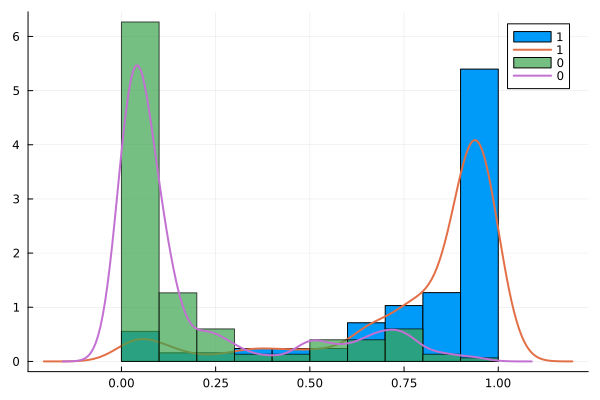

In [26]:
histogram(test_pred_1, normalize=true, bins=10, label=1)
density!(test_pred_1, label=1, linewidth=2)
histogram!(test_pred_0, normalize=true, bins=10, label=0, seriesalpha=0.7)
density!(test_pred_0, label=0, linewidth=2)


The more non-overlapping distributions the better predictive model.

#### Wizard model - ideal predicitons

In [27]:
ideal_pred_1 = ideal_pred[test_dataset.class .== 1]
ideal_pred_0 = ideal_pred[test_dataset.class .== 0];

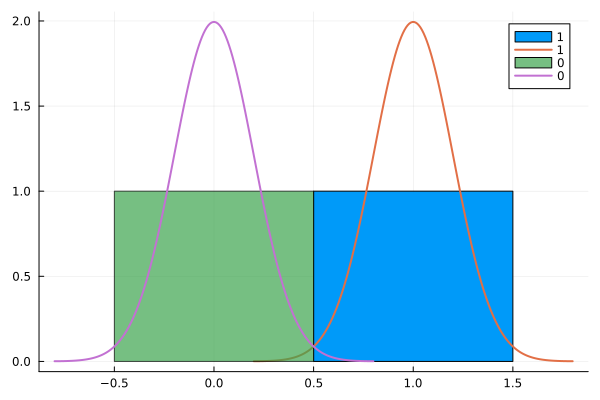

In [28]:
histogram(ideal_pred_1.-0.5, normalize=true, bins=10, label=1)
density!(ideal_pred_1, label=1, bandwidth=.2, linewidth=2)
histogram!(ideal_pred_0.-0.5, normalize=true, bins=10, label=0, seriesalpha=0.7)
density!(ideal_pred_0, label=0, bandwidth=0.2, linewidth=2)


No overlapping scores between $Y=1$ and $Y=0$ is equivalent with a perfect model. Some overlapped kernel densities above results from high bandwidth hyperparameter used in kerned density estimation procedure, but empiracally there's no overlap.

#### Random model

In [29]:
random_pred_1 = random_pred[test_dataset.class .== 1]
random_pred_0 = random_pred[test_dataset.class .== 0];

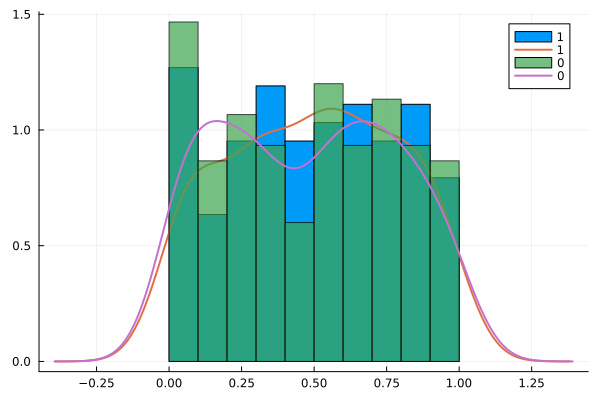

In [30]:
histogram(random_pred_1, normalize=true, bins=10, label=1)
density!(random_pred_1, label=1, linewidth=2)
histogram!(random_pred_0, normalize=true, bins=10, label=0, seriesalpha=0.7)
density!(random_pred_0, label=0, linewidth=2)

Both distribution overlap heavily each other and are difficult to be distinguished. This is a sign of very poor predictive performance.

*Preparation of this workshop has been supported by the Polish National Agency for Academic Exchange under the Strategic Partnerships programme, grant number BPI/PST/2021/1/00069/U/00001.*

![SGH & NAWA](../logo.png)